In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# Data Laoding and quick EDA

In [ ]:
 # getting the data
# gdown link format  https://drive.google.com/uc?id{from the sharedlink after/d}

!gdown https://drive.google.com/uc?id=1ZEPUDN8yAen0STB5-CUI8yfAJTwsm9O8

Downloading...
From: https://drive.google.com/uc?id=1ZEPUDN8yAen0STB5-CUI8yfAJTwsm9O8
To: /content/bitcoin.csv
100% 284k/284k [00:00<00:00, 82.1MB/s]


In [ ]:
df = pd.read_csv('/content/bitcoin.csv',parse_dates=["date"], index_col=["date"])
df.head()

,price,total_volume,market_cap,coin_name
date,,,,
2015-01-01,313.992,4.699936e+07,4.293958e+09,bitcoin
2015-01-02,314.446,3.885591e+07,4.301448e+09,bitcoin
2015-01-03,286.572,1.187789e+08,3.921358e+09,bitcoin
2015-01-04,260.936,2.055001e+08,3.571640e+09,bitcoin
2015-01-05,273.220,1.550381e+08,3.740880e+09,bitcoin


In [ ]:
df.tail()

,price,total_volume,market_cap,coin_name
date,,,,
2024-02-18,51684.517493,1.985188e+10,1.015778e+12,bitcoin
2024-02-19,52138.485789,1.702588e+10,1.023586e+12,bitcoin
2024-02-20,51764.313185,2.255512e+10,1.016146e+12,bitcoin
2024-02-21,52286.793726,3.449963e+10,1.026424e+12,bitcoin
2024-02-22,51842.756766,3.062425e+10,1.018870e+12,bitcoin


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3339 entries, 2015-01-01 00:00:00 to 2024-02-22 00:00:00
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         3339 non-null   float64
 1   total_volume  3339 non-null   float64
 2   market_cap    3338 non-null   float64
 3   coin_name     3339 non-null   object 
dtypes: float64(3), object(1)
memory usage: 130.4+ KB


In [ ]:
len(df)

3339

In [ ]:
max(df.index),min(df.index)

(Timestamp('2024-02-22 00:00:00'), Timestamp('2015-01-01 00:00:00'))

* The dataset contains bitcoin prices data from  2017-01-01 till 2024-02-22


In [ ]:
timesteps = df.index.to_list()
btc_price = df['price'].to_list()

timesteps[:5] ,btc_price[:5]

([Timestamp('2015-01-01 00:00:00'),
  Timestamp('2015-01-02 00:00:00'),
  Timestamp('2015-01-03 00:00:00'),
  Timestamp('2015-01-04 00:00:00'),
  Timestamp('2015-01-05 00:00:00')],
 [313.9920000000001, 314.446, 286.572, 260.936, 273.22])

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

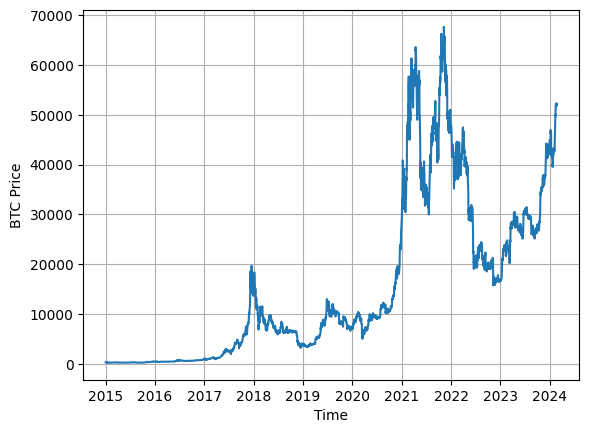

In [ ]:
plot_time_series(timesteps,btc_price,format="-")

In [ ]:
# Only want price for each day
bitcoin_prices = pd.DataFrame(df["price"])

bitcoin_prices.head()

,price
date,
2015-01-01,313.992
2015-01-02,314.446
2015-01-03,286.572
2015-01-04,260.936
2015-01-05,273.220


# Evaluation functions

In [ ]:
# MASE
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

#Model 0: Naïve forecast (baseline)

In [ ]:
split_size = int(0.8 * len(btc_price))
X_train, y_train = timesteps[:split_size], btc_price[:split_size]
X_test, y_test = timesteps[split_size:], btc_price[split_size:]

In [ ]:
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value

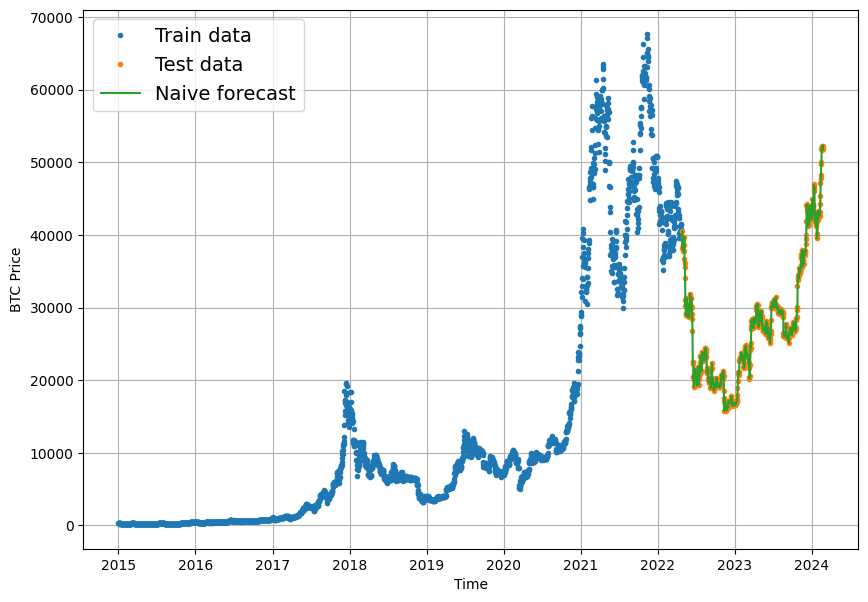

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

In [ ]:
# Evalaute naive model

naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results


{'mae': 495.35916,
 'mse': 585970.0,
 'rmse': 765.48676,
 'mape': 1.8135216,
 'mase': 1.0056676}

# Modelling expriments

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict horizon


For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA|
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |



## impelemnting functions to evaluate the models

In [ ]:
import tensorflow as tf

def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day

  return mae / mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
  # float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # handeling if the larger dimentionality for larger horizons
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

# Formatting Data: windowing the dataset:

example
```
[0, 1, 2, 3, 4, 5, 6] -> [7]  # use the first 7 days to get the 8th prediction and so on..
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
HORIZON = 1  # Predict the next day
WINDOW_SIZE = 7 #  using the past week

In [ ]:
def get_labelled_windows(x, horizon=HORIZON):
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# testing the function out
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8),axis=0), horizon=1)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


i will write a function which:
1. Creates a window step of specific window size, for example: `[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

In [ ]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. creating a window step of specific size [add the horizion at the end for labelling later]
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. create a 2D array of mutliple window steps [minus one to account for zero indexing]
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T  #2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target arrary with 2D arry of multiple window steps
  x= np.array(x)
  windowed_array = x[window_indexes]
  # print(windowed_array[0],windowed_array[-1])

  # 4. get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon= horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(btc_price, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows)

3332

In [ ]:
len(btc_price)

3339

In [ ]:
# Displaying the first 5 windows
for i in range(5):
  print(f"Window: {full_windows[i]} -> Label  {full_labels[i]}")

Window: [313.992  314.446  286.572  260.936  273.22   285.3738 295.8725] -> Label  [284.4525]
Window: [314.446  286.572  260.936  273.22   285.3738 295.8725 284.4525] -> Label  [289.5738]
Window: [286.572  260.936  273.22   285.3738 295.8725 284.4525 289.5738] -> Label  [274.533]
Window: [260.936  273.22   285.3738 295.8725 284.4525 289.5738 274.533 ] -> Label  [267.184]
Window: [273.22   285.3738 295.8725 284.4525 289.5738 274.533  267.184 ] -> Label  [268.3536677]


# Windoweing  the data using tf.keras.preprocessing.timeseries_dataset_from_array

In [ ]:
window_size = 7
shift = 1

dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    btc_price,
    targets=None,
    sequence_length=window_size + 1,
    sequence_stride=shift,
    batch_size=1
)

In [ ]:
# Extracting data from the dataset
data_list = []
for data in dataset:
    data_list.append(data.numpy().flatten())
columns = [f"Day_{i+1}" for i in range(7)]
columns.append('Label')
df = pd.DataFrame(data_list, columns=columns)
df

,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Label
0,313.992004,314.446014,286.571991,260.936005,273.220001,285.373810,295.872498,284.452515
1,314.446014,286.571991,260.936005,273.220001,285.373810,295.872498,284.452515,289.573792
2,286.571991,260.936005,273.220001,285.373810,295.872498,284.452515,289.573792,274.532990
3,260.936005,273.220001,285.373810,295.872498,284.452515,289.573792,274.532990,267.183990
4,273.220001,285.373810,295.872498,284.452515,289.573792,274.532990,267.183990,268.353668
...,...,...,...,...,...,...,...,...
3327,47768.996094,48189.882812,50050.136719,49732.144531,51790.167969,51958.230469,52166.433594,51684.515625
3328,48189.882812,50050.136719,49732.144531,51790.167969,51958.230469,52166.433594,51684.515625,52138.484375
3329,50050.136719,49732.144531,51790.167969,51958.230469,52166.433594,51684.515625,52138.484375,51764.312500
3330,49732.144531,51790.167969,51958.230469,52166.433594,51684.515625,52138.484375,51764.312500,52286.792969


# Turning windows into training and test sets


In [ ]:
def make_train_test_Splits(windows, labels, test_split=0.2):
  # the index that would be used for slicing
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]

  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, train_labels, test_windows, test_labels

In [ ]:
train_windows, train_labels, test_windows, test_labels = make_train_test_Splits(full_windows, full_labels)

len(train_windows), len(test_windows)

(2665, 667)

# Modelling checkpoint

In [ ]:
# function to implement a model checkpoint with a specific file name
def create_model_checkpoint(model_name, save_path='model_expriments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_path,model_name),
                                            monitor = 'val_loss',
                                            verbose= 0,
                                            save_best_only = True )

# Model 1: Dense model : Window = 7 , Horizon = 1

simple dense model :
* single dense layer with 128 hidden units
* output layer with a linear activation
* Batch size = 128
* Epochs = 100

In [ ]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name= 'model_1_dense')

# compiling
model_1.compile(optimizer='adam', loss='mae' , metrics = ['mae','mse'])

# fitting
model_1.fit(x= train_windows,
            y= train_labels,
            epochs=100,
            verbose= 1,
            batch_size=128 ,
            validation_data=(test_windows,test_labels),
            callbacks= [create_model_checkpoint(model_name = model_1.name)])

Epoch 1/100
21/21 [==============================] - 2s 46ms/step - loss: 5264.0605 - mae: 5264.0605 - mse: 115626568.0000 - val_loss: 4878.6348 - val_mae: 4878.6348 - val_mse: 27975082.0000
Epoch 2/100
21/21 [==============================] - 1s 26ms/step - loss: 1184.4720 - mae: 1184.4720 - mse: 6178207.0000 - val_loss: 1262.8127 - val_mae: 1262.8127 - val_mse: 2983914.5000
Epoch 3/100
21/21 [==============================] - 1s 27ms/step - loss: 751.5991 - mae: 751.5991 - mse: 2479918.5000 - val_loss: 1128.9448 - val_mae: 1128.9448 - val_mse: 2477939.0000
Epoch 4/100
21/21 [==============================] - 1s 27ms/step - loss: 653.4243 - mae: 653.4243 - mse: 1905015.7500 - val_loss: 862.0745 - val_mae: 862.0745 - val_mse: 1683127.8750
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 602.4004 - mae: 602.4004 - mse: 1610199.1250 - val_loss: 902.6775 - val_mae: 902.6775 - val_mse: 1703579.8750
Epoch 6/100
21/21 [==============================] - 1s 26ms/step - 

In [ ]:
# Evalaute the model
model_1.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 504.8287 - mae: 504.8287 - mse: 590347.0625


[504.82867431640625, 504.82867431640625, 590347.0625]

In [ ]:
# loading the best saved model and evalaute on test_data
model_1 = tf.keras.models.load_model('model_expriments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 496.7855 - mae: 496.7855 - mse: 585710.8125


[496.7855224609375, 496.7855224609375, 585710.8125]

In [ ]:
# makeing forecasts on the test dataset
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
# Model 1 preds
model_1_preds = make_preds(model_1, test_windows)
model_1_results = evaluate_preds(y_true =  tf.squeeze(test_labels), y_pred= model_1_preds)
model_1_results

21/21 [==============================] - 0s 1ms/step


{'mae': 496.78534,
 'mse': 585710.7,
 'rmse': 765.3174,
 'mape': 1.8264556,
 'mase': 1.008563}

In [ ]:
naive_results

{'mae': 495.35916,
 'mse': 585970.0,
 'rmse': 765.48676,
 'mape': 1.8135216,
 'mase': 1.0056676}

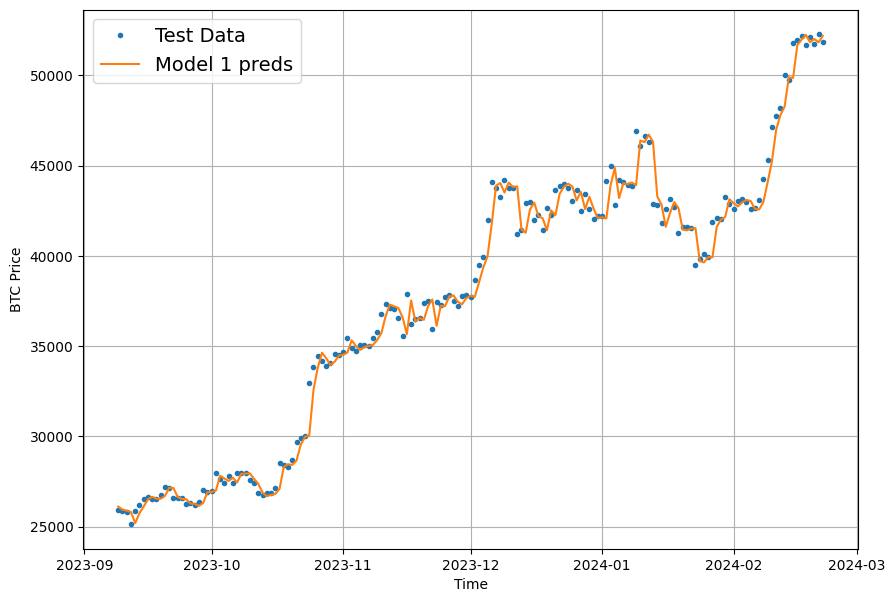

In [ ]:
# plotting model 1 predictions
offset= 500
plt.figure(figsize=(10,7))

plot_time_series(timesteps= X_test[-len(test_windows):], values= test_labels[:,0], start=offset, format='.', label= "Test Data")
plot_time_series(timesteps= X_test[-len(test_windows):], values= model_1_preds, start=offset, format='-', label= "Model 1 preds")

# Model 2: Dense model : Window = 30 , Horizon = 1

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

# make windowed data with the new window size
full_windows, full_labels = make_windows(btc_price, window_size=WINDOW_SIZE, horizon=HORIZON)

# make train and test windows
train_windows, train_labels, test_windows, test_labels = make_train_test_Splits(full_windows, full_labels)

len(train_windows) , len(test_windows)

(2647, 662)

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name= 'model_2_dense')

# compiling
model_2.compile(loss='mae', optimizer='adam')

# fitting
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=129,
            verbose = 0,
            validation_data=(test_windows,test_labels),
            callbacks = [create_model_checkpoint(model_name = model_2.name)] )


In [ ]:
# Evalaute the model on test data
model_2.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 680.3046


680.3045654296875

In [ ]:
# loading the best perorming model
model_2 = tf.keras.models.load_model('model_expriments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 3ms/step - loss: 517.3904


517.390380859375

In [ ]:
# Get the forecast preds
model_2_preds = make_preds(model_2, test_windows)
model_2_results = evaluate_preds(y_true =  tf.squeeze(test_labels), y_pred= model_2_preds)
model_2_results

21/21 [==============================] - 0s 3ms/step


{'mae': 517.3903,
 'mse': 610895.94,
 'rmse': 781.5983,
 'mape': 1.9145327,
 'mase': 1.0561787}

In [ ]:
model_1_results

{'mae': 496.78534,
 'mse': 585710.7,
 'rmse': 765.3174,
 'mape': 1.8264556,
 'mase': 1.008563}

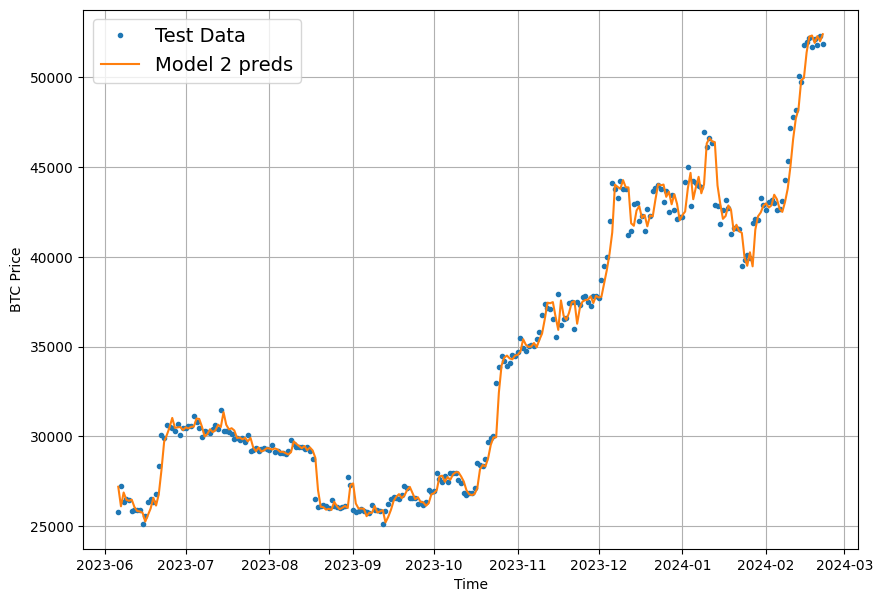

In [ ]:
offset= 400
plt.figure(figsize=(10,7))

plot_time_series(timesteps= X_test[-len(test_windows):], values= test_labels[:,0], start=offset, format='.', label= "Test Data")
plot_time_series(timesteps= X_test[-len(test_windows):], values= model_2_preds, start=offset, format='-', label= "Model 2 preds")

# Model 3: Dense model : Window = 30 , Horizon = 7

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

# make windowed data with the new window size
full_windows, full_labels = make_windows(btc_price, window_size=WINDOW_SIZE, horizon=HORIZON)

# make train and test windows
train_windows, train_labels, test_windows, test_labels = make_train_test_Splits(full_windows, full_labels)

len(train_windows) , len(test_windows)

(2642, 661)

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_3_dense')

# Compiling
model_3.compile(loss= 'mae', optimizer='adam')

# fitting
model_3.fit(x=train_windows,
            y= train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# Evaluate model_3 on test data
model_3.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 3ms/step - loss: 1396.8003


1396.80029296875

In [ ]:
# laoding the best model
model_3 = tf.keras.models.load_model('model_expriments/model_3_dense')
model_3.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 1090.2218


1090.2218017578125

In [ ]:
# Making forecasts with the model
model_3_preds = make_preds(model_3,test_windows)

model_3_results = evaluate_preds(y_true =tf.squeeze(test_labels), y_pred = model_3_preds)
model_3_results


21/21 [==============================] - 0s 2ms/step


{'mae': 1090.2218,
 'mse': 2829687.0,
 'rmse': 1257.68,
 'mape': 4.045431,
 'mase': 2.2192686}

In [ ]:
naive_results

{'mae': 495.35916,
 'mse': 585970.0,
 'rmse': 765.48676,
 'mape': 1.8135216,
 'mase': 1.0056676}

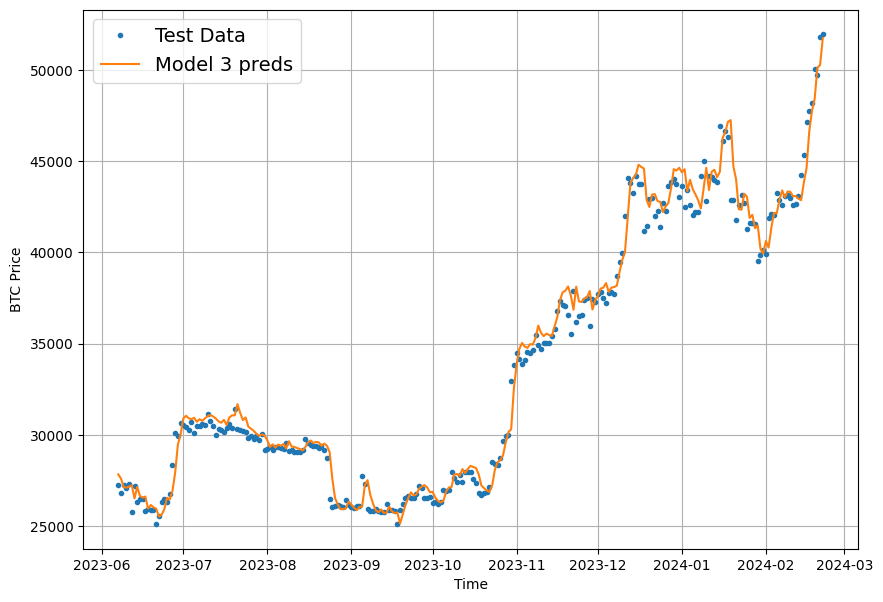

In [ ]:
# visualizing
offset= 400
plt.figure(figsize=(10,7))

plot_time_series(timesteps= X_test[-len(test_windows):], values= test_labels[:,0], start=offset, format='.', label= "Test Data")
plot_time_series(timesteps= X_test[-len(test_windows):], values= tf.reduce_mean(model_3_preds, axis=1), start=offset, format='-', label= "Model 3 preds")

# visaulizing the model expriments uptill now

<Axes: >

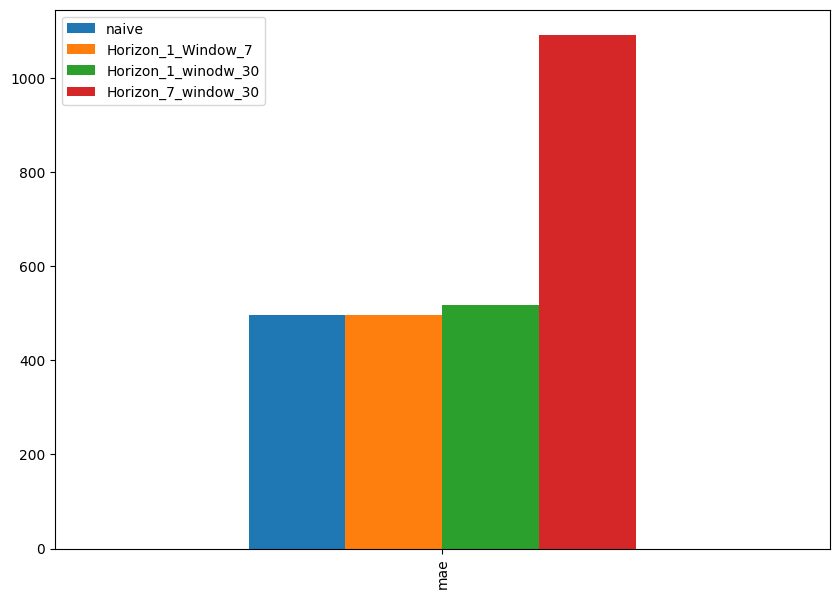

In [ ]:
pd.DataFrame({'naive':naive_results['mae'],
              'Horizon_1_Window_7': model_1_results['mae'],
              'Horizon_1_winodw_30':model_2_results['mae'],
              'Horizon_7_window_30':model_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

* from the previous chart it's obvious that using HORION of 1 and WINDOW 7 yeilds a better results.

# Model 4 : conv 1D

to use conv 1D we need to reshape the data in this shape :(batch_size,  time_steps, input_dim)

In [ ]:
HORIZON = 1
WINDOW = 7
# windowed data
full_windows, full_labels = make_windows(btc_price, window_size= WINDOW, horizon =HORIZON)
# Train and test sets
train_windows, train_labels, test_windows, test_labels = make_train_test_Splits(full_windows, full_labels)

len(train_windows) ,len(test_windows)

(2665, 667)

In [ ]:
# to be added in the model layers instead of preprocessing the data before hand manually
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))  # adding extra dimention to the input_dim

In [ ]:
tf.random.set_seed(42)

# Model_building
model_4 = tf.keras.Sequential([
    expand_dims_layer,
    layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_4_conv1D')

# compiling
model_4.compile(loss='mae', optimizer='adam')

# fitting
model_4.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs=100,
            verbose=0,
            validation_data = (test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name= model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Evaluating the model
model_4.evaluate(test_windows,test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 531.6962


531.6961669921875

In [ ]:
# loading the best preforming model
model_4 = tf.keras.models.load_model('model_expriments/model_4_conv1D')
model_4.evaluate(test_windows,test_labels)

21/21 [==============================] - 1s 7ms/step - loss: 503.9554


503.95538330078125

In [ ]:
# making forecasting predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_results = evaluate_preds(y_true= tf.squeeze(test_labels), y_pred= model_4_preds)
model_4_results

21/21 [==============================] - 0s 2ms/step


{'mae': 503.9553,
 'mse': 599259.2,
 'rmse': 774.11835,
 'mape': 1.8569717,
 'mase': 1.0231193}

# Model 5: LSTM

In [ ]:
tf.random.set_seed(42)

# Model_building
model_5 = tf.keras.Sequential([
    expand_dims_layer,
    layers.LSTM(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_5_LSTM')

# compiling
model_5.compile(loss='mae', optimizer='adam')

# fitting
model_5.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs=100,
            verbose=1,
            validation_data = (test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name= model_5.name)])

Epoch 1/100
21/21 [==============================] - 8s 233ms/step - loss: 7070.2891 - val_loss: 4460.8115
Epoch 2/100
21/21 [==============================] - 3s 169ms/step - loss: 1103.8519 - val_loss: 1294.6680
Epoch 3/100
21/21 [==============================] - 4s 200ms/step - loss: 780.5046 - val_loss: 1069.7397
Epoch 4/100
21/21 [==============================] - 4s 182ms/step - loss: 686.2289 - val_loss: 970.7914
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 677.5413 - val_loss: 987.3241
Epoch 6/100
21/21 [==============================] - 3s 157ms/step - loss: 669.7302 - val_loss: 962.4095
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 645.9510 - val_loss: 1117.9681
Epoch 8/100
21/21 [==============================] - 4s 196ms/step - loss: 626.9551 - val_loss: 833.2516
Epoch 9/100
21/21 [==============================] - 0s 14ms/step - loss: 614.3293 - val_loss: 923.2059
Epoch 10/100
21/21 [==============================] 

In [ ]:
# loading the best preforming model
model_5 = tf.keras.models.load_model('model_expriments/model_5_LSTM')
model_5.evaluate(test_windows,test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 508.6481


508.64813232421875

In [ ]:
# making forecasting predictions
model_5_preds = make_preds(model_5, test_windows)
model_5_results = evaluate_preds(y_true= tf.squeeze(test_labels), y_pred= model_5_preds)
model_5_results

21/21 [==============================] - 0s 2ms/step


{'mae': 508.64795,
 'mse': 611550.25,
 'rmse': 782.0168,
 'mape': 1.8730663,
 'mase': 1.0326462}

In [ ]:
model_1_results

{'mae': 496.78534,
 'mse': 585710.7,
 'rmse': 765.3174,
 'mape': 1.8264556,
 'mase': 1.008563}

In [ ]:
timesteps[0]

Timestamp('2015-01-01 00:00:00')

# Making Multivariate timeseries

i will incoprate the bitcoin halving event

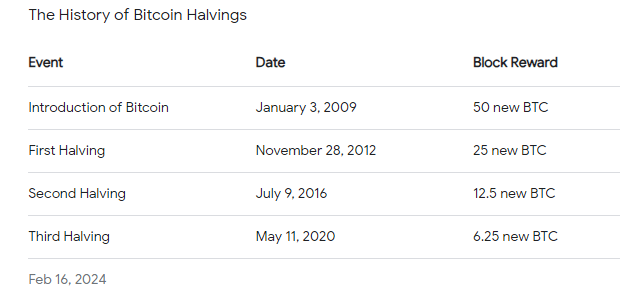

In [ ]:
bitcoin_prices

,price
date,
2015-01-01,313.992000
2015-01-02,314.446000
2015-01-03,286.572000
2015-01-04,260.936000
2015-01-05,273.220000
...,...
2024-02-18,51684.517493
2024-02-19,52138.485789
2024-02-20,51764.313185


In [ ]:
block_reward_1 = 50  # wont be included as the historical data starts from 2015
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# block rewards dates
block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-11')

In [ ]:
# for block reward for all the dates between 2012-11-28 and 2016-07-09 the block_rewards would be 25
# for block reward for all the dates between 2016-07-09 and 2020-05-11 the block_rewards would be 12.5
# for block reward for all the dates after 2020-05-11 the block_rewards would be 6.25

# getting the ranges to be used as indecies to assign the block rewards
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days  # the number of days present in our data before the 3rd halving
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days  # the number of days present in our data before the 4rth halving

block_reward_2_days, block_reward_3_days

(555, 1957)

In [ ]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# adding the values of block rewards
bitcoin_prices_block.iloc[:block_reward_2_days,-1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days: ,-1] = block_reward_4

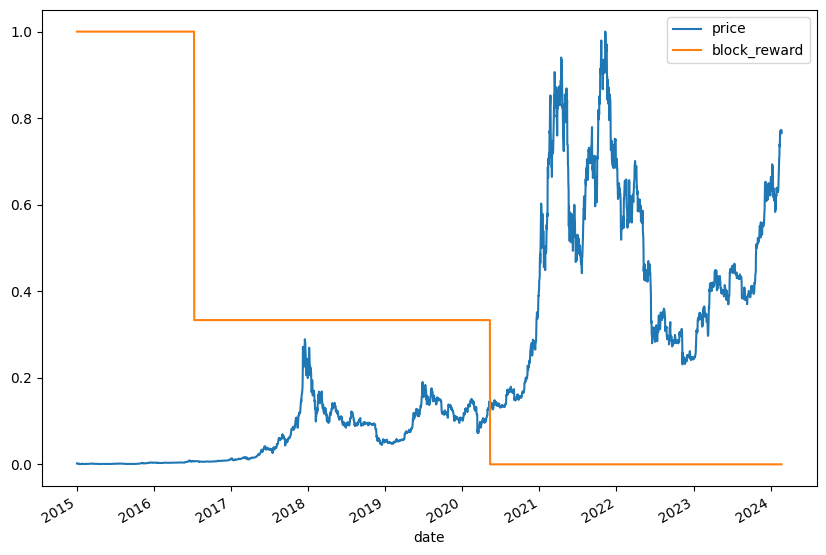

In [ ]:
# plotting the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[['price','block_reward']]),
                                     columns = bitcoin_prices_block.columns,
                                     index = bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10,7));

* preparing windowed multi variate dataset using `pandas.shift()` method

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7


In [ ]:
bitcoin_prices_windowed  = bitcoin_prices_block.copy()

# adding windowed columns
# shifting the values for each step in window size
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f'price+{i+1}'] = bitcoin_prices_windowed['price'].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,price,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
date,,,,,,,,,
2015-01-01,313.9920,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,314.4460,25,313.9920,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,286.5720,25,314.4460,313.9920,NaN,NaN,NaN,NaN,NaN
2015-01-04,260.9360,25,286.5720,314.4460,313.9920,NaN,NaN,NaN,NaN
2015-01-05,273.2200,25,260.9360,286.5720,314.4460,313.9920,NaN,NaN,NaN
2015-01-06,285.3738,25,273.2200,260.9360,286.5720,314.4460,313.992,NaN,NaN
2015-01-07,295.8725,25,285.3738,273.2200,260.9360,286.5720,314.446,313.992,NaN
2015-01-08,284.4525,25,295.8725,285.3738,273.2200,260.9360,286.572,314.446,313.992
2015-01-09,289.5738,25,284.4525,295.8725,285.3738,273.2200,260.936,286.572,314.446


our windowed data should be looking like this:
```
[0, 1, 2, 3, 4, 5, 6, block_Reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_Reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_Reward] -> [9]
```

In [ ]:
#  splitting the data into x and y
X = bitcoin_prices_windowed.dropna().drop('price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['price'].astype(np.float32)

X.head()

,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
date,,,,,,,,
2015-01-08,25.0,295.872498,285.373810,273.220001,260.936005,286.571991,314.446014,313.992004
2015-01-09,25.0,284.452515,295.872498,285.373810,273.220001,260.936005,286.571991,314.446014
2015-01-10,25.0,289.573792,284.452515,295.872498,285.373810,273.220001,260.936005,286.571991
2015-01-11,25.0,274.532990,289.573792,284.452515,295.872498,285.373810,273.220001,260.936005
2015-01-12,25.0,267.183990,274.532990,289.573792,284.452515,295.872498,285.373810,273.220001


In [ ]:
y.head()

date
2015-01-08    284.452515
2015-01-09    289.573792
2015-01-10    274.532990
2015-01-11    267.183990
2015-01-12    268.353668
Name: price, dtype: float32

In [ ]:
# splitting the data into train and test sets

split_size = int(len(X)*0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train) ,len(X_test)

(2665, 667)

# Model 6 : Dense model using the multi variate data

In [ ]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name= 'model_6_dense_multivariate')

# compiling
model_6.compile(optimizer='adam', loss='mae' , metrics ='mae')

# fitting
model_6.fit(x= X_train,
            y= y_train,
            epochs=100,
            verbose= 1,
            batch_size=128 ,
            validation_data=(X_test, y_test),
            callbacks= [create_model_checkpoint(model_name = model_6.name)])

Epoch 1/100
21/21 [==============================] - 2s 88ms/step - loss: 5060.9780 - mae: 5060.9780 - val_loss: 4055.8398 - val_mae: 4055.8398
Epoch 2/100
21/21 [==============================] - 1s 34ms/step - loss: 1035.8938 - mae: 1035.8938 - val_loss: 1006.4304 - val_mae: 1006.4304
Epoch 3/100
21/21 [==============================] - 1s 26ms/step - loss: 639.4665 - mae: 639.4665 - val_loss: 968.7009 - val_mae: 968.7009
Epoch 4/100
21/21 [==============================] - 1s 27ms/step - loss: 582.9065 - mae: 582.9065 - val_loss: 801.1727 - val_mae: 801.1727
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 561.1793 - mae: 561.1793 - val_loss: 873.5439 - val_mae: 873.5439
Epoch 6/100
21/21 [==============================] - 1s 27ms/step - loss: 537.0270 - mae: 537.0270 - val_loss: 708.9612 - val_mae: 708.9612
Epoch 7/100
21/21 [==============================] - 1s 25ms/step - loss: 500.0762 - mae: 500.0762 - val_loss: 670.9381 - val_mae: 670.9381
Epoch 8/100
2

In [ ]:
# loading the best saved model and evalaute on test_data
model_6 = tf.keras.models.load_model('model_expriments/model_6_dense_multivariate')
model_6.evaluate(X_test, y_test)

21/21 [==============================] - 0s 2ms/step - loss: 497.5485 - mae: 497.5485


[497.5484924316406, 497.5484924316406]

In [ ]:
# making forecasting
model_6_preds = make_preds(model_6, X_test)
model_6_results = evaluate_preds(y_true = tf.squeeze(y_test), y_pred = model_6_preds)
model_6_results

21/21 [==============================] - 0s 1ms/step


{'mae': 497.54855,
 'mse': 588802.56,
 'rmse': 767.3347,
 'mape': 1.8289828,
 'mase': 1.0101125}

In [ ]:
model_1_results

{'mae': 496.78534,
 'mse': 585710.7,
 'rmse': 765.3174,
 'mape': 1.8264556,
 'mase': 1.008563}

# Model 7 : N-Beats algorithim replicatting  
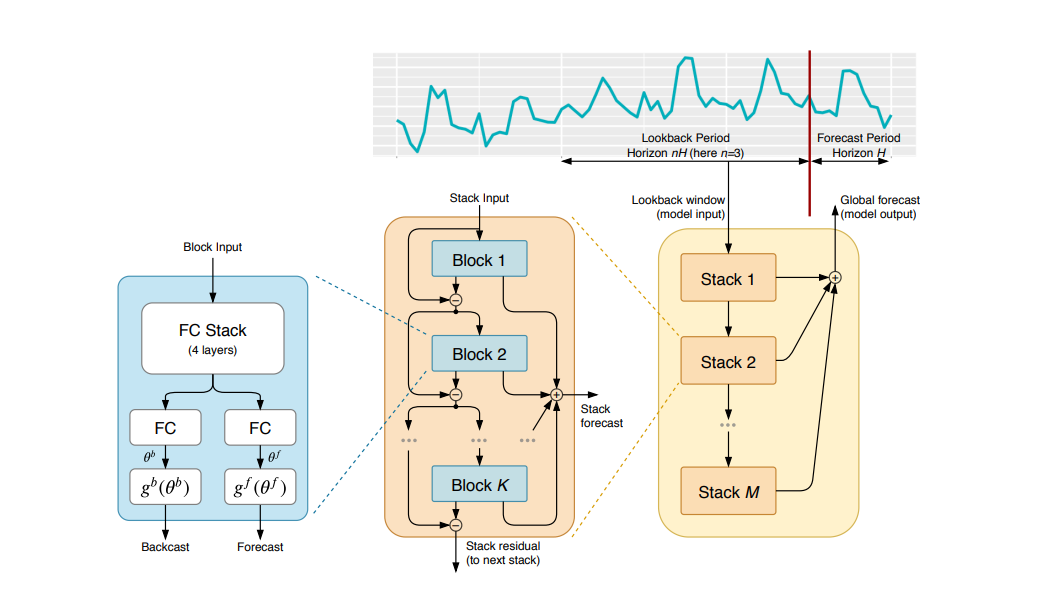

## building and testing the N_beats block layer

Because N-BEATS block layer doesn't exist in TF, we would create it.

and to create a custom layers and models in TF we can use subclassing

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
              input_size:int,
              theta_size:int,
              horizon:int,
              n_neurons:int,
              n_layers:int,
              **kwargs):# **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name, etc...)

    super().__init__(**kwargs)
    self.input_size = input_size  #block_input (window size)
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # block contains a stack of 4 fully connected layers each has relu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu')for _ in range(n_layers)]
    # output block is a theta layer with a linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs):
    x=inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast,forecast



In [ ]:
# setting dummy nbeatsblock layer to preview inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size = WINDOW_SIZE,
                                       theta_size= WINDOW_SIZE+HORIZON,
                                       horizon = HORIZON,
                                       n_neurons=128,
                                       n_layers = 4)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+ 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
#passing the dummy inputs into block
# activation outputs of theta layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
tf.squeeze(backcast).numpy()

array([ 0.08780205, -1.0519753 , -0.5428586 ,  0.53276366,  0.37493193,
        0.55733943, -0.4230499 ], dtype=float32)

In [ ]:
tf.squeeze(forecast).numpy()

1.3257321

## Preparing the data for the N-BEATS algorithim using `tf.data`

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

# add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f'price+{i+1}'] =bitcoin_prices_nbeats['price'].shift(periods=i+1)
bitcoin_prices_nbeats.head(10)


,price,price+1,price+2,price+3,price+4,price+5,price+6,price+7
date,,,,,,,,
2015-01-01,313.9920,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,314.4460,313.9920,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,286.5720,314.4460,313.9920,NaN,NaN,NaN,NaN,NaN
2015-01-04,260.9360,286.5720,314.4460,313.9920,NaN,NaN,NaN,NaN
2015-01-05,273.2200,260.9360,286.5720,314.4460,313.9920,NaN,NaN,NaN
2015-01-06,285.3738,273.2200,260.9360,286.5720,314.4460,313.992,NaN,NaN
2015-01-07,295.8725,285.3738,273.2200,260.9360,286.5720,314.446,313.992,NaN
2015-01-08,284.4525,295.8725,285.3738,273.2200,260.9360,286.572,314.446,313.992
2015-01-09,289.5738,284.4525,295.8725,285.3738,273.2200,260.936,286.572,314.446


In [ ]:
# splitting the data into X and y
X = bitcoin_prices_nbeats.dropna().drop('price', axis=1)
y = bitcoin_prices_nbeats.dropna()['price']

#splitting the data into train and test sets
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test,  y_test = X[split_size:], y[split_size:]

len(X_train) , len(X_test)

(2665, 667)

In [ ]:
# making the data performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# combining features and labels by zipping(feature,labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## setting the hyperparameters for NBeats algorithim

In [ ]:
# The values are found in table 18 in Nbeats paper
N_EPOCHS = 5000
N_NEURONS = 512 #width
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

*  **Residual connections :**
N-BEATS algorithim uses a double residual stacking to help train it's deeper architrcture

## Building, compiling and fitting the N_BEATS ALgorithim

steps:
1. setup an instance of the N_BEATS block layer `NbeatsBlock`( this will be the intial block used for the network, the rest will be created as part of stacks)

2. createing an input layer using Functional API

3. making intial backcast and forecast for the model with the layer created in (1)

4. using for loop to create a stacks of block layer

5. using thr `NbeatsBlock` class within the for loop in (4) to create blocks which return backcast and block-level forecasts

6. creating the double residual stacking using subtract and add layers

7. put the model inputs and outputs usng `tf.keras.Model()`

8. compile the model with MAE loss and ADAM optimizer with the default hyperparameters

9. Fit N-BEATS for 5000 epochs and since it's fitting for many epochs i will use callbacks like:
  * Early stopping.
  * REducing LR on plateau (lowering the learning rate if the model stops improving)

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])




Epoch 215: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 331: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 431: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 1h 34min 2s, sys: 59.5 s, total: 1h 35min 1s
Wall time: 1h 7min 29s


In [ ]:
# Evalaute
model_7.evaluate(test_dataset)


1/1 [==============================] - 0s 499ms/step - loss: 501.4813 - mae: 501.4813 - mse: 598425.3125


[501.48126220703125, 501.48126220703125, 598425.3125]

In [ ]:
# Making preds
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([40526.49 , 38390.08 , 39244.176, 39594.086, 38682.883, 38142.96 ,
       38353.67 , 38661.344, 38052.33 , 39437.22 ], dtype=float32)>

In [ ]:
y_test[0]

38134.21545068938

In [ ]:
# Evalaute preds
model_7_results = evaluate_preds(y_true= y_test, y_pred= tf.squeeze(model_7_preds))
model_7_results

{'mae': 501.48126,
 'mse': 598425.3,
 'rmse': 773.5795,
 'mape': 1.8448088,
 'mase': 1.0180966}

In [ ]:
model_1_results

{'mae': 496.78534,
 'mse': 585710.7,
 'rmse': 765.3174,
 'mape': 1.8264556,
 'mase': 1.008563}

## Architecture block

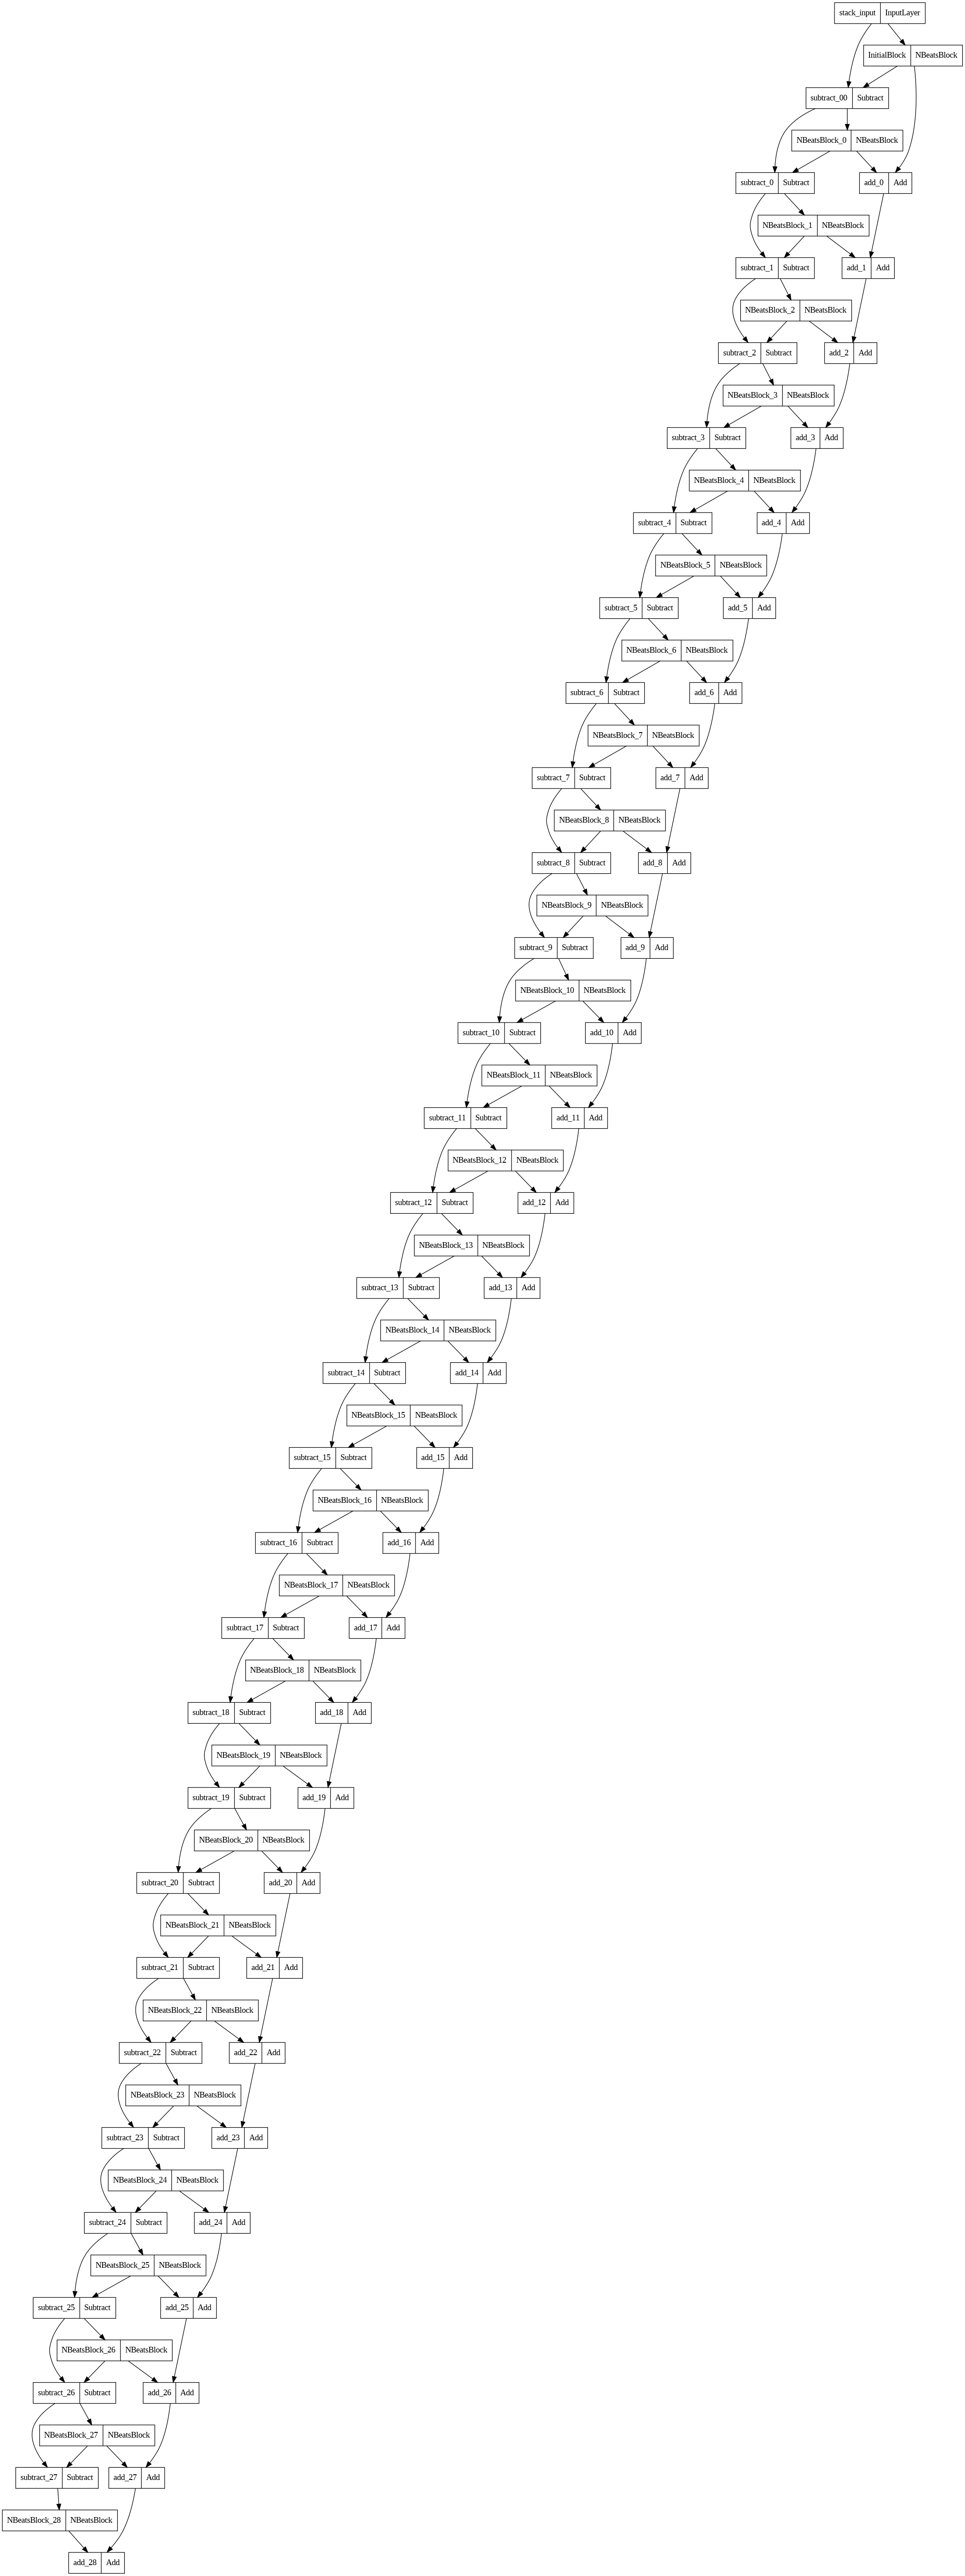

In [ ]:
plot_model(model_7)

# Model 8 : Ensemble

* Ensemble using different loss functions

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data= train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_funs=['mae','mse','mape']):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss funs.

  Eg. if num_iter = 10 , a list of 30 trained models will be returned.
      10 * len(['mae','mse','mape'])
  """

  # Empty list for trained ensmble models
  ensemble_models =[]

  # Create a num_iter number of models per loss function
  for i in range(num_iter):
    # Building and fitting a new model with a different loss fun.
    for loss_function in loss_funs:
      print(f'Optimizing model by reducing: {loss_function} for {num_epochs}, model number{i}')

      # constructing a sumple model simillar to model_1
      model = tf.keras.Sequential([
          # INtializing dense layes with normal distribution for estimating prediction intervals
          layers.Dense(128, kernel_initializer="he_normal", activation= 'relu'),
          layers.Dense(128, kernel_initializer="he_normal", activation= 'relu'),
          layers.Dense(HORIZON, activation='linear')])

      # Compiling the model with the current loss fun.
      model.compile(loss=loss_function, optimizer='adam', metrics=['mae','mse'])

      # Fitting the current model
      model.fit(train_data,
                epochs = num_epochs,
                verbose=0,
                validation_data = test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights= True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', paitence= 100, verbose = 1)])
      # Appending the fitted model to the list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time

# getting the list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5, num_epochs=1000)

## Making predections with ensemble models

In [ ]:
# function to use a list of trained models and return an list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds=[]

  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models= ensemble_models, data = test_dataset)
ensemble_preds

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


<tf.Tensor: shape=(15, 667), dtype=float32, numpy=
array([[40325.797, 38768.66 , 39173.637, ..., 52200.855, 52038.516,
        52342.387],
       [40458.42 , 38586.664, 39026.266, ..., 51964.996, 51590.09 ,
        52279.06 ],
       [40332.25 , 38465.883, 39196.402, ..., 51952.508, 51805.016,
        52146.125],
       ...,
       [40356.816, 38186.824, 38976.023, ..., 51939.22 , 51872.73 ,
        52250.664],
       [40465.06 , 38266.1  , 39258.39 , ..., 52162.22 , 51760.914,
        52324.25 ],
       [40352.824, 38259.7  , 38799.523, ..., 52315.91 , 51757.688,
        52140.67 ]], dtype=float32)>

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)

In [ ]:
# Evaluating ensemble model using mean
ensemble_results = evaluate_preds(y_true= y_test, y_pred= ensemble_mean)
ensemble_results

{'mae': 497.20178,
 'mse': 587633.44,
 'rmse': 766.5725,
 'mape': 1.8297551,
 'mase': 1.0094085}

In [ ]:
# Evaluating ensemble model using median
ensemble_results = evaluate_preds(y_true= y_test, y_pred= ensemble_median)
ensemble_results

{'mae': 497.35437,
 'mse': 586877.2,
 'rmse': 766.0791,
 'mape': 1.8292497,
 'mase': 1.0097183}

In [ ]:
model_1_results

{'mae': 496.78534,
 'mse': 585710.7,
 'rmse': 765.3174,
 'mape': 1.8264556,
 'mase': 1.008563}

## Getting 95% confidence prediction intervals using bootstrap method .
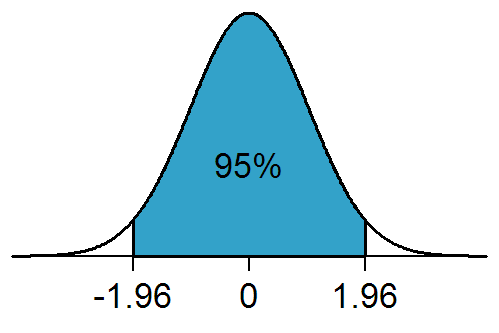


steps:
1. taking the prediction of a number of randomly intialzied models `ensemble_models`

2. measuring the standard deviation of the prediction

3. Multiplying the stnadard deviation by 1.96 (assuming that the distribution is Gussian/Normal, 95% of the observations falls within 1.96 standard deviation of the mean)

4. to get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)



In [ ]:
def get_upper_lower(preds):
  # 2, the std of the preds
  std = tf.math.reduce_std(preds, axis = 0)

  # 3. Multipying std by 1.96
  interval = 1.96 * std

  # 4. getting upper and lower bounds or a prediction
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower,upper = preds_mean - interval, preds_mean + interval

  return lower, upper


In [ ]:
# getting the upper and lower bounds for ensemble preds
lower, upper = get_upper_lower(ensemble_preds)

In [ ]:
X_test

,price+1,price+2,price+3,price+4,price+5,price+6,price+7
date,,,,,,,
2022-04-27,40488.877918,39469.049862,39561.780191,39756.848993,40528.541487,41397.220477,41498.122447
2022-04-28,38134.215451,40488.877918,39469.049862,39561.780191,39756.848993,40528.541487,41397.220477
2022-04-29,39237.949317,38134.215451,40488.877918,39469.049862,39561.780191,39756.848993,40528.541487
2022-04-30,39741.766646,39237.949317,38134.215451,40488.877918,39469.049862,39561.780191,39756.848993
2022-05-01,38650.550138,39741.766646,39237.949317,38134.215451,40488.877918,39469.049862,39561.780191
...,...,...,...,...,...,...,...
2024-02-18,52166.434310,51958.230291,51790.169298,49732.145370,50050.136095,48189.881793,47768.995251
2024-02-19,51684.517493,52166.434310,51958.230291,51790.169298,49732.145370,50050.136095,48189.881793
2024-02-20,52138.485789,51684.517493,52166.434310,51958.230291,51790.169298,49732.145370,50050.136095


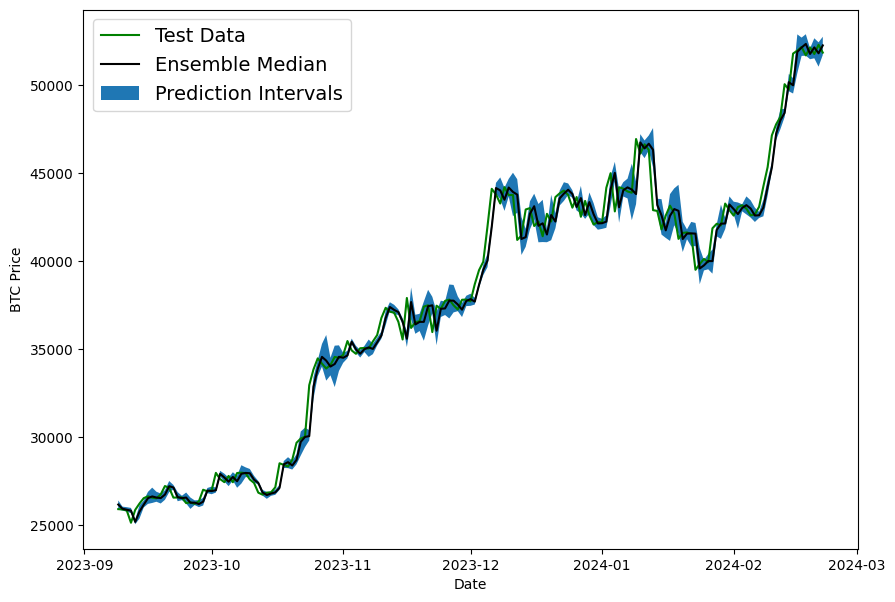

In [ ]:
# plotting the ensemble predictions along with the prediction intervals
offset=500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g" , label='Test Data')
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-" , label='Ensemble Median')
plt.xlabel('Date')
plt.ylabel('BTC Price')

# using fill between to plot the upper and lower bounds
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label='Prediction Intervals')

plt.legend(loc= 'upper left', fontsize=14);

# Model 9 : Training a model on the full historical data to make predictions on the future

all the previous models predicted the testdataset which is only a pseudo future

so the following Model is capable of predicting into the future.


In [ ]:
bitcoin_prices_windowed.tail()

,price,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
date,,,,,,,,,
2024-02-18,51684.517493,6.25,52166.434310,51958.230291,51790.169298,49732.145370,50050.136095,48189.881793,47768.995251
2024-02-19,52138.485789,6.25,51684.517493,52166.434310,51958.230291,51790.169298,49732.145370,50050.136095,48189.881793
2024-02-20,51764.313185,6.25,52138.485789,51684.517493,52166.434310,51958.230291,51790.169298,49732.145370,50050.136095
2024-02-21,52286.793726,6.25,51764.313185,52138.485789,51684.517493,52166.434310,51958.230291,51790.169298,49732.145370
2024-02-22,51842.756766,6.25,52286.793726,51764.313185,52138.485789,51684.517493,52166.434310,51958.230291,51790.169298


In [ ]:
# Training the model on all the data to predict for the next day
X_all = bitcoin_prices_windowed.dropna().drop(['price','block_reward'],axis=1).to_numpy()
y_all =  bitcoin_prices_windowed.dropna()['price'].to_numpy()

len(X_all), len(y_all)

(3332, 3332)

In [ ]:
# Turn data into efficent running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

#combining features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all,labels_dataset_all))

#batch and prefetch
BATCH_SIZE=1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
# modeling
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_9_future')

#compiling
model_9.compile(loss ='mae', optimizer= 'adam')

#Fitting
model_9.fit(dataset_all, epochs=100, verbose=0)

## Making predictions into the future

In [ ]:
# forecasting 2 weeks
INTO_FUTURE = 14

To make a prediction into the future i will create a function that does the following:

1. Takes as input:
  * a list of values [Bitcoin historical data]
  * a trained model `model_9`
  * a window into the future to predict `INTO_FUTURE`
  * The window size that the model was trained on - since the model can only predict on the same kind of data it was trained on.

2. Creates an empty lsit for future forecast [this will be returned at the end when it's full of predictions] and extracts the last `WINDOW_SIZE` values from the input values

3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remmove the first value and append the latest prediction.




In [ ]:
def predict_future(values, model, future_steps, window_size=WINDOW):
  future_preds = []

  input_window = values[-window_size:]

  for _ in range(future_steps):
    # making prediction using the last window
    pred = model.predict(tf.expand_dims(input_window, axis= 0))
    print(f"predicting on \n {input_window} -> prediction: {tf.squeeze(pred).numpy()} \n")
    future_preds.append(tf.squeeze(pred).numpy())

    # appending the new forecast to the input window and slicing to get the an updated input window [shifting]
    input_window = np.append(input_window, pred)[-WINDOW_SIZE:]

  return future_preds

In [ ]:
bitcoin_prices_windowed.tail()

,price,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
date,,,,,,,,,
2024-02-18,51684.517493,6.25,52166.434310,51958.230291,51790.169298,49732.145370,50050.136095,48189.881793,47768.995251
2024-02-19,52138.485789,6.25,51684.517493,52166.434310,51958.230291,51790.169298,49732.145370,50050.136095,48189.881793
2024-02-20,51764.313185,6.25,52138.485789,51684.517493,52166.434310,51958.230291,51790.169298,49732.145370,50050.136095
2024-02-21,52286.793726,6.25,51764.313185,52138.485789,51684.517493,52166.434310,51958.230291,51790.169298,49732.145370
2024-02-22,51842.756766,6.25,52286.793726,51764.313185,52138.485789,51684.517493,52166.434310,51958.230291,51790.169298


In [ ]:
future_preds= predict_future(values=y_all, model=model_9, future_steps=INTO_FUTURE, window_size=WINDOW)
future_preds

1/1 [==============================] - 0s 206ms/step
predicting on 
 [51958.23029105 52166.43430976 51684.51749265 52138.48578874
 51764.31318549 52286.79372555 51842.75676626] -> prediction: 51786.8359375 

1/1 [==============================] - 0s 98ms/step
predicting on 
 [52166.43430976 51684.51749265 52138.48578874 51764.31318549
 52286.79372555 51842.75676626 51786.8359375 ] -> prediction: 51883.6796875 

1/1 [==============================] - 0s 90ms/step
predicting on 
 [51684.51749265 52138.48578874 51764.31318549 52286.79372555
 51842.75676626 51786.8359375  51883.6796875 ] -> prediction: 51558.84765625 

1/1 [==============================] - 0s 49ms/step
predicting on 
 [52138.48578874 51764.31318549 52286.79372555 51842.75676626
 51786.8359375  51883.6796875  51558.84765625] -> prediction: 51985.71484375 

1/1 [==============================] - 0s 41ms/step
predicting on 
 [51764.31318549 52286.79372555 51842.75676626 51786.8359375
 51883.6796875  51558.84765625 51985.7148

[51786.836,
 51883.68,
 51558.848,
 51985.715,
 51608.426,
 51978.652,
 51604.008,
 51600.95,
 51658.707,
 51431.777,
 51781.23,
 51424.453,
 51702.156,
 51383.555]

## Plotting the Future forecasts

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Return array of the dates ranging from the start date till the number of into future dates we wanna get
  """
  start_date = start_date + np.timedelta64(offset, "D") #adding a day to the start date
  end_date = start_date + np.timedelta64(into_future,"D") #specifying the end date

  return np.arange(start_date, end_date, dtype='datetime64[D]')

In [ ]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2024-02-22 00:00:00')

In [ ]:
# Getting the dates for the next 2 weeks
future_dates = get_future_dates(last_timestep, INTO_FUTURE)
future_dates

array(['2024-02-23', '2024-02-24', '2024-02-25', '2024-02-26',
       '2024-02-27', '2024-02-28', '2024-02-29', '2024-03-01',
       '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-05',
       '2024-03-06', '2024-03-07'], dtype='datetime64[D]')

In [ ]:
# Inserting the last timestep to the future dates so that the plot doesnt become 'janky' (disjoint)
future_dates = np.insert(future_dates,0, last_timestep)
future_preds = np.insert(future_preds,0, btc_price[-1])


(array(['2024-02-22', '2024-02-22', '2024-02-22', '2024-02-23',
        '2024-02-24', '2024-02-25', '2024-02-26', '2024-02-27',
        '2024-02-28', '2024-02-29', '2024-03-01', '2024-03-02',
        '2024-03-03', '2024-03-04', '2024-03-05', '2024-03-06',
        '2024-03-07'], dtype='datetime64[D]'),
 array([51842.758, 51842.758, 51786.836, 51883.68 , 51558.848, 51985.715,
        51608.426, 51978.652, 51604.008, 51600.95 , 51658.707, 51431.777,
        51781.23 , 51424.453, 51702.156, 51383.555], dtype=float32))

In [ ]:
future_dates, future_preds

(array(['2024-02-22', '2024-02-23', '2024-02-24', '2024-02-25',
        '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29',
        '2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04',
        '2024-03-05', '2024-03-06', '2024-03-07'], dtype='datetime64[D]'),
 array([51842.758, 51786.836, 51883.68 , 51558.848, 51985.715, 51608.426,
        51978.652, 51604.008, 51600.95 , 51658.707, 51431.777, 51781.23 ,
        51424.453, 51702.156, 51383.555], dtype=float32))

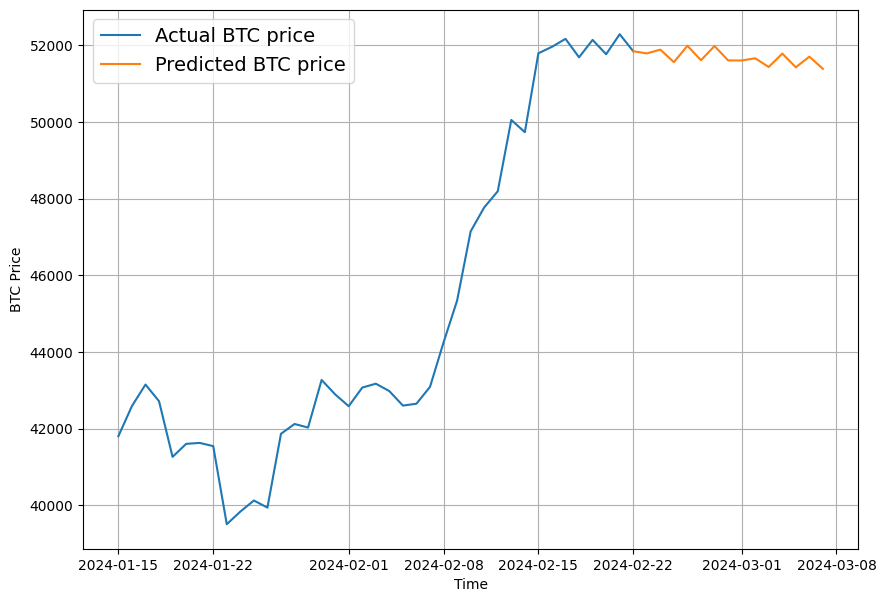

In [ ]:
#plotting the future prices of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start=3300, format='-', label='Actual BTC price')
plot_time_series(future_dates,future_preds, format='-', label='Predicted BTC price')

# Model 10: The Turkey problem 🦃

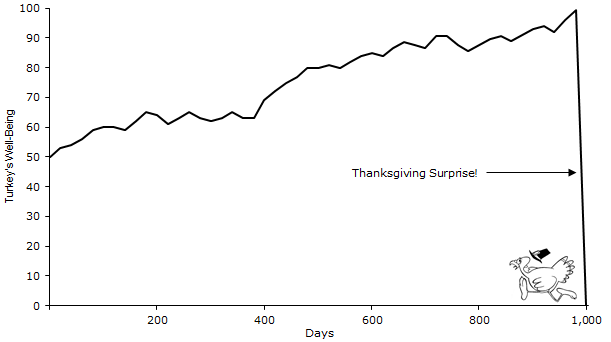

In [ ]:
# Injecting a turkey problem to our BTC prices dataset by making the pric falls 100X on one day
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1]/100

In [ ]:
btc_price_turkey[-10:]

[50050.13609456397,
 49732.14536955351,
 51790.16929752642,
 51958.23029105492,
 52166.43430976192,
 51684.51749264525,
 52138.48578873693,
 51764.313185487765,
 52286.79372554667,
 518.4275676625642]

In [ ]:
#getting the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2024-02-13T00:00:00.000000000', '2024-02-14T00:00:00.000000000',
       '2024-02-15T00:00:00.000000000', '2024-02-16T00:00:00.000000000',
       '2024-02-17T00:00:00.000000000', '2024-02-18T00:00:00.000000000',
       '2024-02-19T00:00:00.000000000', '2024-02-20T00:00:00.000000000',
       '2024-02-21T00:00:00.000000000', '2024-02-22T00:00:00.000000000'],
      dtype='datetime64[ns]')

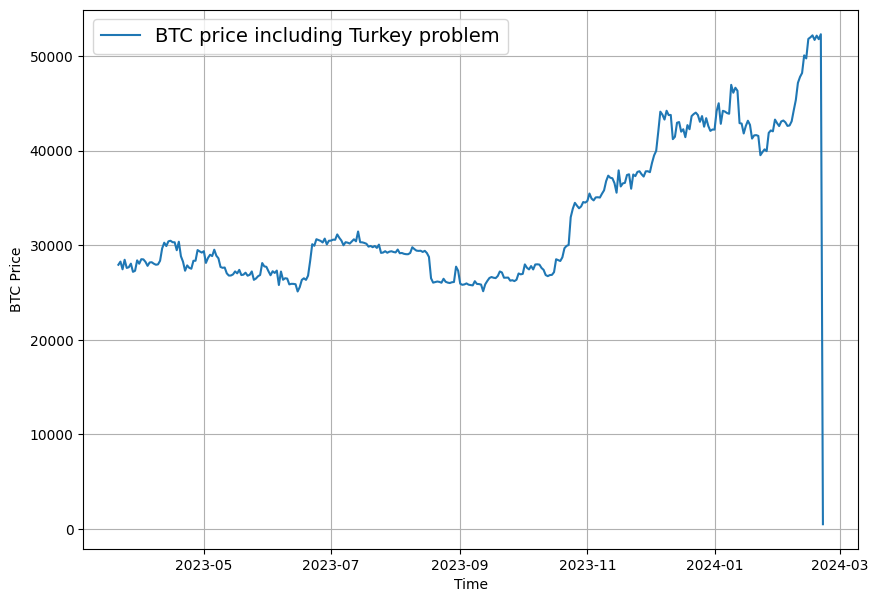

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=btc_timesteps_turkey, values=btc_price_turkey, format='-', label='BTC price including Turkey problem', start=3000 )

In [186]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, y_train, X_test,  y_test = make_train_test_Splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2665, 667, 2665, 667)

In [187]:
# Building turkey model
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [188]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

21/21 [==============================] - 0s 2ms/step - loss: 692.7347


692.7347412109375

In [191]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_expriments/Turkey_Model")
turkey_model.evaluate(X_test, y_test)

21/21 [==============================] - 0s 4ms/step - loss: 571.1479


571.14794921875

In [192]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)

# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test, y_pred=turkey_preds)
turkey_results

21/21 [==============================] - 0s 6ms/step


{'mae': 8948.127,
 'mse': 133037160.0,
 'rmse': 10994.262,
 'mape': 41.444145,
 'mase': 15.708638}

In [193]:
model_1_results

{'mae': 496.78534,
 'mse': 585710.7,
 'rmse': 765.3174,
 'mape': 1.8264556,
 'mase': 1.008563}

## Visualizing turkey predictions

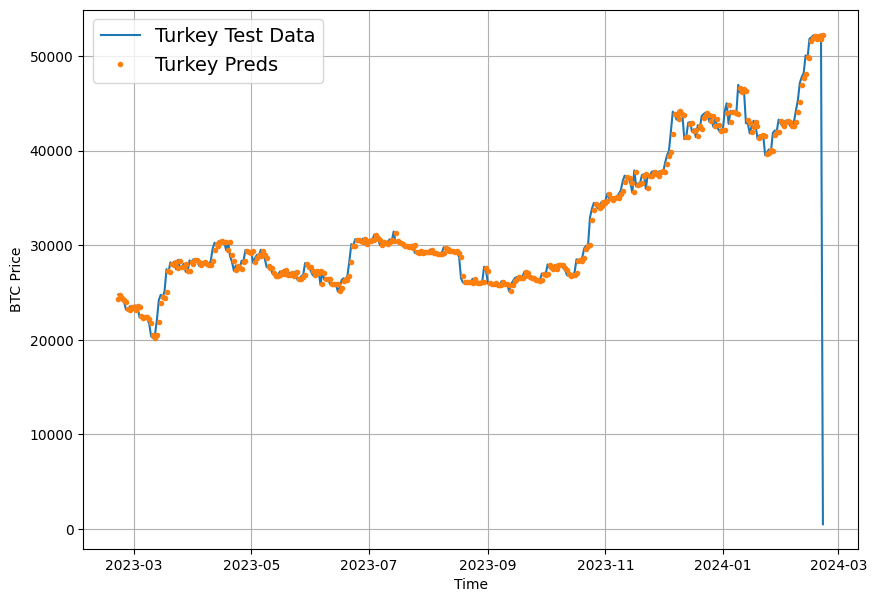

In [195]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)

plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

# Finally visualizing all model expriments done so far

In [196]:
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,495.359161,5.859700e+05,765.486755,1.813522,1.005668
model_1_dense_w7_h1,496.785339,5.857107e+05,765.317383,1.826456,1.008563
model_2_dense_w30_h1,517.390320,6.108959e+05,781.598328,1.914533,1.056179
model_3_dense_w30_h7,1090.221802,2.829687e+06,1257.680054,4.045431,2.219269
model_4_CONV1D,503.955292,5.992592e+05,774.118347,1.856972,1.023119
model_5_LSTM,508.647949,6.115502e+05,782.016785,1.873066,1.032646
model_6_multivariate,497.548553,5.888026e+05,767.334717,1.828983,1.010113
model_8_NBEATs,501.481262,5.984253e+05,773.579529,1.844809,1.018097
model_9_ensemble,497.354370,5.868772e+05,766.079102,1.829250,1.009718
model_10_turkey,8948.126953,1.330372e+08,10994.261719,41.444145,15.708638


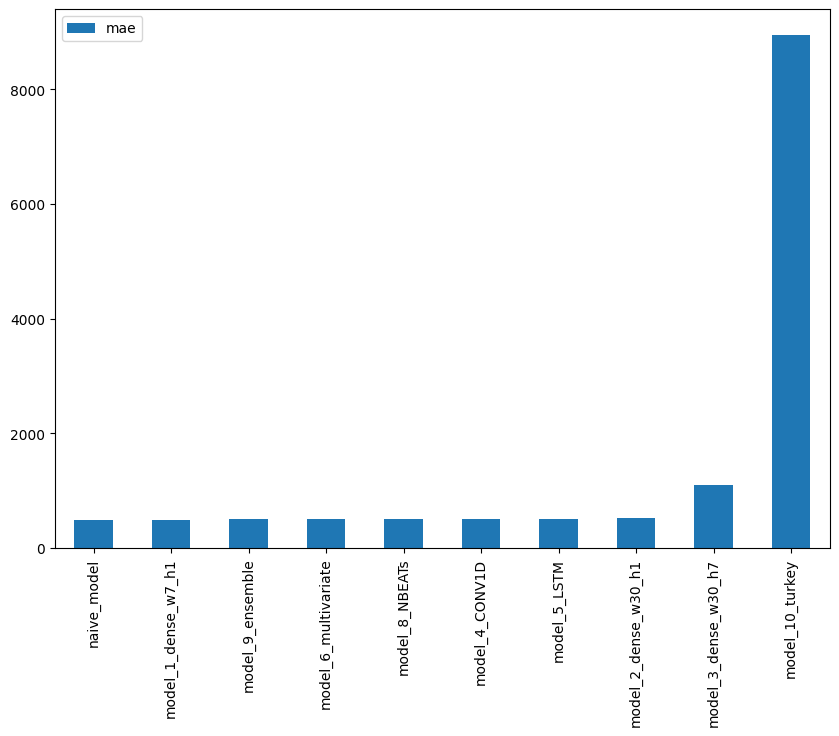

In [197]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");